In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipdb
import platform
import h5py
import time
import scipy.io
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline

# MRI imports
# -----------
import nibabel as nb
import cortex

cmap = 'BuBkRd'
cmap_steps = 255
vmin,vmax = -1,1

# define colormap
def get_col(data,cmap,vmin,vmax,cmap_steps):

    base = cortex.utils.get_cmap(cmap)
    val = np.linspace(0, 1,cmap_steps+1,endpoint=False)
    colmap = colors.LinearSegmentedColormap.from_list(  'my_colmap',
                                                        base(val),
                                                        N = cmap_steps)

    vrange = float(vmax) - float(vmin)
    norm_data = ((data-float(vmin))/vrange)*cmap_steps
    color_val = colmap(norm_data.astype(int))
    
    return(color_val)

In [2]:
# Define analysis parameters
# --------------------------
with open('/home/szinte/projects/retino_HCP/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
base_dir = analysis_info["{}_base_folder".format(platform.uname()[1])] 
base_dir_indiv = analysis_info["{}_base_folder_indiv".format(platform.uname()[1])] 
fit_model = 'gauss'            
mask_dir= 'all'

sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11

subjects =['999999']
for sub in analysis_info['subject_list']:subjects.append(sub)
subjects.append('sub-000')

In [3]:
pprf_rsqr_mean    = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_rsqr_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_rsqr_sem     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

nprf_rsqr_mean    = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_rsqr_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_rsqr_sem     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

pprf_prop           = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_prop_std       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_prop_sem       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

nprf_prop           = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_prop_std       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_prop_sem       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

for roi_num, roi in enumerate(analysis_info['rois']):
    for subject_num, subject in enumerate(subjects[:-1]):
        
        if subject == 'sub-01':bs_dir = base_dir_indiv
        elif subject == 'sub-02':bs_dir = base_dir_indiv
        else:bs_dir = base_dir

        h5_dir = opj(bs_dir,'pp_data',subject,fit_model,'h5')

        data_hemi = []
        for hemi in ['L', 'R']:

            folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
            h5_file = h5py.File(opj(h5_dir,'{roi}.h5'.format(roi = roi)), "r")
            in_file = opj("prf_deriv_{hemi}_{mask_dir}".format(hemi = hemi, mask_dir = mask_dir))
            data = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]
            data = data[:,:].T
            data_hemi.append(data)
        
        data_LR = np.row_stack((data_hemi[0],data_hemi[1]))

        rsq_mask = data_LR[:,rsq_idx]
        rsq_mat = data_LR[:,rsq_idx]
        rsq_mat = rsq_mat[~np.isnan(rsq_mask)]
        sign_mat = data_LR[:,sign_idx]
        sign_mat = sign_mat[~np.isnan(rsq_mask)]
        pprf_rsqr = rsq_mat[sign_mat>0.0]
        nprf_rsqr = rsq_mat[sign_mat<0.0]
        nprf_rsqr = nprf_rsqr*-1.0
        
        pprf_rsqr_mean[subject_num,roi_num] = np.nanmean(pprf_rsqr,axis = 0)
        pprf_rsqr_std[subject_num,roi_num]  = np.nanstd(pprf_rsqr,axis=0,ddof=1)
        pprf_rsqr_sem[subject_num,roi_num]  = np.nanstd(pprf_rsqr,axis=0,ddof=1)/np.sqrt(pprf_rsqr.shape[0])
        
        nprf_rsqr_mean[subject_num,roi_num] = np.nanmean(nprf_rsqr,axis = 0)
        nprf_rsqr_std[subject_num,roi_num]  = np.nanstd(nprf_rsqr,axis=0,ddof=1)
        nprf_rsqr_sem[subject_num,roi_num]  = np.nanstd(nprf_rsqr,axis=0,ddof=1)/np.sqrt(nprf_rsqr.shape[0])
        
        pprf_prop[subject_num,roi_num] = np.nansum(sign_mat==1)/sign_mat.shape[0]
        nprf_prop[subject_num,roi_num] = (np.nansum(sign_mat==-1)/sign_mat.shape[0])*-1.0

In [4]:
# compute average across HCP subjects
for roi_num, roi in enumerate(analysis_info['rois']):
    pprf_rsqr_mean[-1,roi_num]      = np.nanmean(pprf_rsqr_mean[3:-1,roi_num],axis = 0)
    pprf_rsqr_std[-1,roi_num]       = np.nanstd(pprf_rsqr_mean[3:-1,roi_num],axis=0,ddof=1)
    
    nprf_rsqr_mean[-1,roi_num]      = np.nanmean(nprf_rsqr_mean[3:-1,roi_num],axis = 0)
    nprf_rsqr_std[-1,roi_num]       = np.nanstd(nprf_rsqr_mean[3:-1,roi_num],axis=0,ddof=1)

    pprf_prop[-1,roi_num]           = np.nanmean(pprf_prop[3:-1,roi_num],axis = 0)
    pprf_prop_std[-1,roi_num]       = np.nanstd(pprf_prop[3:-1,roi_num],axis=0,ddof=1)
    
    nprf_prop[-1,roi_num]           = np.nanmean(nprf_prop[3:-1,roi_num],axis = 0)
    nprf_prop_std[-1,roi_num]       = np.nanstd(nprf_prop[3:-1,roi_num],axis=0,ddof=1)

In [7]:
def plot_fig2B():
    
#     all_sub2draw = [184,0,1,2]
    all_sub2draw = [0]
    
    # define figure
    fig = plt.figure(figsize=(7.09*2.54, 3.75*2.54))
    grid = plt.GridSpec(6,4,hspace = 3,wspace = 0.2)

    ax0 = fig.add_subplot(grid[0:6, 0:1])
    ax0.axis('off')
    ax1 = fig.add_subplot(grid[0:2, 2])
    ax2 = fig.add_subplot(grid[0:2, 3])
    ax3 = fig.add_subplot(grid[2:4, 2])
    ax4 = fig.add_subplot(grid[2:4, 3])
    ax5 = fig.add_subplot(grid[4:6, 2])
    ax6 = fig.add_subplot(grid[4:6, 3])

    # Settings
    title_font = {'loc':'left','fontname':'Helvetica', 'fontsize':7, 'fontweight':'bold'}
    axis_tick_font = {'fontname':'Helvetica', 'fontsize':6}
    axis_label_font = {'fontname':'Helvetica', 'fontsize':7}
    
    ymin1,ymax1 = -1,1
    ymin2,ymax2 = -1,1
    ymin3,ymax3 = -1,1
    ymin4,ymax4 = -1,1
    ymin5,ymax5 = -1,1
    ymin6,ymax6 = -1,1
    y_tick_num1 = 5 
    y_tick_num2 = 5 
    y_tick_num3 = 5
    y_tick_num4 = 5
    y_tick_num5 = 5
    y_tick_num6 = 5
    
    early_vis_rois_len = np.arange(len(analysis_info['early_vis_rois']))
    late_vis_rois_len = np.arange(len(analysis_info['late_vis_rois']))
    dmn_rois_len = np.arange(len(analysis_info['dmn_rois']))
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75

    axs = ['ax1','ax2','ax3','ax4','ax5','ax6']

    # Titles
    ax1.set_title('Low level vision areas',**title_font)
    ax3.set_title('High level vision areas',**title_font)
    ax5.set_title('Default network areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # Y lim
    ax1.set_ylim(bottom=ymin1, top=ymax1)
    ax2.set_ylim(bottom=ymin2, top=ymax2)
    ax3.set_ylim(bottom=ymin3, top=ymax3)
    ax4.set_ylim(bottom=ymin4, top=ymax4)
    ax5.set_ylim(bottom=ymin5, top=ymax5)
    ax6.set_ylim(bottom=ymin6, top=ymax6)

    # Y label
    ax1.set_ylabel('pRF R\u00b2',axis_label_font)
    ax2.set_ylabel('pRF\npolarity ratio (%)',axis_label_font)
    ax3.set_ylabel('pRF R\u00b2',axis_label_font)
    ax4.set_ylabel('pRF\npolarity ratio (%)',axis_label_font)
    ax5.set_ylabel('pRF R\u00b2',axis_label_font)
    ax6.set_ylabel('pRF\npolarity ratio (%)',axis_label_font)

    # Y Ticks
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    y_tick3 = np.linspace(ymin3,ymax3,y_tick_num3)
    y_tick4 = np.linspace(ymin4,ymax4,y_tick_num4)
    y_tick5 = np.linspace(ymin5,ymax5,y_tick_num5)
    y_tick6 = np.linspace(ymin6,ymax6,y_tick_num6)
    ax1.set_yticks(y_tick1)
    ax2.set_yticks(y_tick2)
    ax3.set_yticks(y_tick3)
    ax4.set_yticks(y_tick4)
    ax5.set_yticks(y_tick5)
    ax6.set_yticks(y_tick6)

    # Y Tick label
    y_tick_label1 = []
    for t in zip(np.abs(y_tick1)):y_tick_label1.append('%1.2g'%t)
    y_tick_label2 = []
    for t in zip(np.abs(y_tick2)):y_tick_label2.append('%1.2g'%t)
    y_tick_label3 = []
    for t in zip(np.abs(y_tick3)):y_tick_label3.append('%1.2g'%t)
    y_tick_label4 = []
    for t in zip(np.abs(y_tick4)):y_tick_label4.append('%1.2g'%t)
    y_tick_label5 = []
    for t in zip(np.abs(y_tick5)):y_tick_label5.append('%1.2g'%t)
    y_tick_label6 = []
    for t in zip(np.abs(y_tick6)):y_tick_label6.append('%1.2g'%t)
    ax1.set_yticklabels(y_tick_label1,**axis_tick_font)
    ax2.set_yticklabels(y_tick_label2,**axis_tick_font)
    ax3.set_yticklabels(y_tick_label3,**axis_tick_font)
    ax4.set_yticklabels(y_tick_label4,**axis_tick_font)
    ax5.set_yticklabels(y_tick_label5,**axis_tick_font)
    ax6.set_yticklabels(y_tick_label6,**axis_tick_font)

    # X Ticks
    ax1.set_xticks(early_vis_rois_len)
    ax2.set_xticks(early_vis_rois_len)
    ax3.set_xticks(late_vis_rois_len)
    ax4.set_xticks(late_vis_rois_len)
    ax5.set_xticks(dmn_rois_len)
    ax6.set_xticks(dmn_rois_len)

    # X lim
    ax1.set_xlim(left=early_vis_rois_len[0]-1, right=early_vis_rois_len[-1]+1)
    ax2.set_xlim(left=early_vis_rois_len[0]-1, right=early_vis_rois_len[-1]+1)
    ax3.set_xlim(left=late_vis_rois_len[0]-1, right=late_vis_rois_len[-1]+1)
    ax4.set_xlim(left=late_vis_rois_len[0]-1, right=late_vis_rois_len[-1]+1)
    ax5.set_xlim(left=dmn_rois_len[0]-1, right=dmn_rois_len[-1]+1)
    ax6.set_xlim(left=dmn_rois_len[0]-1, right=dmn_rois_len[-1]+1)

    # X Ticks Label
    ax1.set_xticklabels(analysis_info['early_vis_rois'],**axis_tick_font,rotation = 45)
    ax2.set_xticklabels(analysis_info['early_vis_rois'],**axis_tick_font,rotation = 45)
    ax3.set_xticklabels(analysis_info['late_vis_rois'],**axis_tick_font,rotation = 45)
    ax4.set_xticklabels(analysis_info['late_vis_rois'],**axis_tick_font,rotation = 45)
    ax5.set_xticklabels(analysis_info['dmn_rois'],**axis_tick_font,rotation = 45)
    ax6.set_xticklabels(analysis_info['dmn_rois'],**axis_tick_font,rotation = 45)

    # zero lines
    line_x_early = np.arange(early_vis_rois_len[0]-1,early_vis_rois_len[-1]+2)
    line_x_late = np.arange(late_vis_rois_len[0]-1,late_vis_rois_len[-1]+2)
    line_x_dmn = np.arange(dmn_rois_len[0]-1,dmn_rois_len[-1]+2)
    ax1.plot(line_x_early,line_x_early*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax2.plot(line_x_early,line_x_early*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax3.plot(line_x_late,line_x_late*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax4.plot(line_x_late,line_x_late*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax5.plot(line_x_dmn,line_x_dmn*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax6.plot(line_x_dmn,line_x_dmn*0,color = [0.5,0.5,0.5],linewidth = axis_width)

    # text legend
    early_text_x = early_vis_rois_len[-1]+1 - (early_vis_rois_len[-1]+1)*0.05
    late_text_x = late_vis_rois_len[-1]+1 - (late_vis_rois_len[-1]+1)*0.05
    dmn_text_x = dmn_rois_len[-1]+1 - (dmn_rois_len[-1]+1)*0.05
    ax1.text(early_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax1.text(early_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax2.text(early_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax2.text(early_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax3.text(late_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax3.text(late_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax4.text(late_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax4.text(late_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax5.text(dmn_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax5.text(dmn_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(dmn_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(dmn_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)


    # define bar distance and width
    dist_early = 0.15 * (3.0/len(all_sub2draw))
    dist_late = len(analysis_info['late_vis_rois'])*(dist_early/len(analysis_info['early_vis_rois']))
    dist_dmn = len(analysis_info['dmn_rois'])*(dist_early/len(analysis_info['early_vis_rois']))

    width_early = 0.15 *(3.0/len(all_sub2draw))
    width_late = len(analysis_info['late_vis_rois'])*(width_early/len(analysis_info['early_vis_rois']))
    width_dmn = len(analysis_info['dmn_rois'])*(width_early/len(analysis_info['early_vis_rois']))


    # Plot all data
    # -------------
    for sub2draw_num,sub2draw in enumerate(all_sub2draw):
        if sub2draw == 1:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9]
            rois_dn    = [13,14,15]
        elif sub2draw == 2:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9]
            rois_dn    = [13,14,15]
        else:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9,10,11,12]
            rois_dn    = [13,14,15,16]

        # +pRF/-pRF R2 x values
        ax1_x = np.arange(len(rois_low))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_early*(len(all_sub2draw)/3.0))
        ax3_x = np.arange(len(rois_high)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_late*(len(all_sub2draw)/3.0))
        ax5_x = np.arange(len(rois_dn))   + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_dmn*(len(all_sub2draw)/3.0))

        # +pRF R2
        ax1_y,ax3_y,ax5_y = pprf_rsqr_mean[sub2draw,rois_low],pprf_rsqr_mean[sub2draw,rois_high],pprf_rsqr_mean[sub2draw,rois_dn]
        ax1.bar(ax1_x,ax1_y,color = get_col(ax1_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax3.bar(ax3_x,ax3_y,color = get_col(ax3_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax5.bar(ax5_x,ax5_y,color = get_col(ax5_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax1_yerr = pprf_rsqr_std[sub2draw,rois_low]
            ax3_yerr = pprf_rsqr_std[sub2draw,rois_high]
            ax5_yerr = pprf_rsqr_std[sub2draw,rois_dn]
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr*0,ax1_yerr], xerr=None, ecolor=get_col(ax1_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr*0,ax3_yerr], xerr=None, ecolor=get_col(ax3_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr*0,ax5_yerr], xerr=None, ecolor=get_col(ax5_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr,ax1_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr,ax3_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr,ax5_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # -pRF R2
        ax1_y,ax3_y,ax5_y = nprf_rsqr_mean[sub2draw,rois_low],nprf_rsqr_mean[sub2draw,rois_high],nprf_rsqr_mean[sub2draw,rois_dn]
        ax1.bar(ax1_x,ax1_y,color = get_col(ax1_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax3.bar(ax3_x,ax3_y,color = get_col(ax3_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax5.bar(ax5_x,ax5_y,color = get_col(ax5_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax1_yerr = nprf_rsqr_std[sub2draw,rois_low]
            ax3_yerr = nprf_rsqr_std[sub2draw,rois_high]
            ax5_yerr = nprf_rsqr_std[sub2draw,rois_dn]
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr,ax1_yerr*0], xerr=None, ecolor=get_col(ax1_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr,ax3_yerr*0], xerr=None, ecolor=get_col(ax3_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr,ax5_yerr*0], xerr=None, ecolor=get_col(ax5_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr*0,ax1_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr*0,ax3_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr*0,ax5_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # +pRF/-pRF ratio x values
        ax2_x = np.arange(len(rois_low))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_early*(len(all_sub2draw)/3.0))
        ax4_x = np.arange(len(rois_high)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_late*(len(all_sub2draw)/3.0))
        ax6_x = np.arange(len(rois_dn))   + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_dmn*(len(all_sub2draw)/3.0))

        # +pRF ratio
        ax2_y,ax4_y,ax6_y = pprf_prop[sub2draw,rois_low],pprf_prop[sub2draw,rois_high],pprf_prop[sub2draw,rois_dn]
        ax2.bar(ax2_x,ax2_y,color = get_col(ax2_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax4.bar(ax4_x,ax4_y,color = get_col(ax4_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax6.bar(ax6_x,ax6_y,color = get_col(ax6_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax2_yerr = pprf_prop_std[sub2draw,rois_low]
            ax4_yerr = pprf_prop_std[sub2draw,rois_high]
            ax6_yerr = pprf_prop_std[sub2draw,rois_dn]
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr*0,ax2_yerr], xerr=None, ecolor=get_col(ax2_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr*0,ax4_yerr], xerr=None, ecolor=get_col(ax4_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr*0,ax6_yerr], xerr=None, ecolor=get_col(ax6_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr,ax2_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr,ax4_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr,ax6_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # -pRF ratio
        ax2_y,ax4_y,ax6_y = nprf_prop[sub2draw,rois_low],nprf_prop[sub2draw,rois_high],nprf_prop[sub2draw,rois_dn]
        ax2.bar(ax2_x,ax2_y,color = get_col(ax2_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax4.bar(ax4_x,ax4_y,color = get_col(ax4_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax6.bar(ax6_x,ax6_y,color = get_col(ax6_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax2_yerr = nprf_prop_std[sub2draw,rois_low]
            ax4_yerr = nprf_prop_std[sub2draw,rois_high]
            ax6_yerr = nprf_prop_std[sub2draw,rois_dn]
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr,ax2_yerr*0], xerr=None, ecolor=get_col(ax2_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr,ax4_yerr*0], xerr=None, ecolor=get_col(ax4_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr,ax6_yerr*0], xerr=None, ecolor=get_col(ax6_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr*0,ax2_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr*0,ax4_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr*0,ax6_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

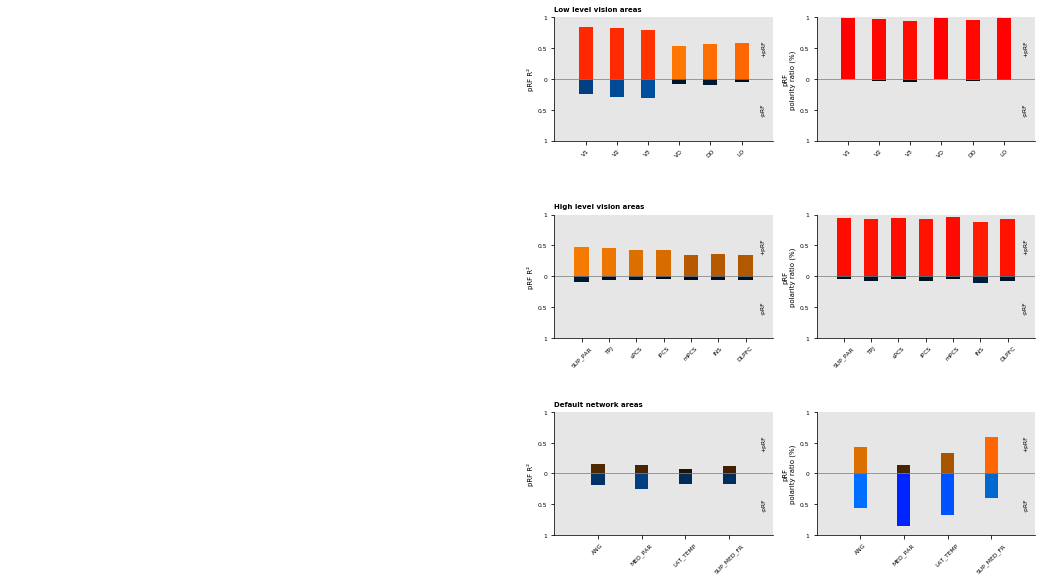

In [9]:
plot_fig2B()
img_dir = '/home/szinte/projects/retino_HCP/post_fit/notebooks/figs/FigureVSS/'
try: os.makedirs(img_dir)
except: pass
plt.savefig("{imdir}polarity_res.pdf".format(imdir = img_dir),facecolor='w')

In [10]:
# Low level visual areas PPRF
rois_low = [0,1,2,3,4,5]
subject2print_num = [0]
for subject_num in subject2print_num:
    
    prf_r2_mean    = np.nanmean(pprf_rsqr_mean[subject_num,rois_low])
    prf_r2_std     = np.nanstd(pprf_rsqr_mean[subject_num,rois_low],axis=0,ddof=1)
    prf_prop_mean  = np.nanmean(pprf_prop[subject_num,rois_low])
    prf_prop_std   = np.nanstd(pprf_prop[subject_num,rois_low],axis=0,ddof=1)

    print("Low level visual areas: {} ({}): +pPR R\u00b2 = {:1.2f} ± {:1.2f}, +pRF ratio: {:1.1f} ± {:1.1f}%".format(   subjects[subject_num],
                                                                                                                        subject_num,
                                                                                                                        prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))

Low level visual areas: 999999 (0): +pPR R² = 0.69 ± 0.14, +pRF ratio: 97.6 ± 2.1%


In [11]:
# High level visual areas PPRF
for subject_num in subject2print_num:
    if subject_num == 1:
        rois_high = [6,7,8,9]
    elif subject_num == 2:
        rois_high = [6,7,8,9]
    else: 
        rois_high = [6,7,8,9,10,11,12]
        
    prf_r2_mean   = np.nanmean(pprf_rsqr_mean[subject_num,rois_high])
    prf_r2_std    = np.nanstd(pprf_rsqr_mean[subject_num,rois_high],axis=0,ddof=1)
    prf_prop_mean = np.nanmean(pprf_prop[subject_num,rois_high])
    prf_prop_std  = np.nanstd(pprf_prop[subject_num,rois_high],axis=0,ddof=1)
    
    print("High level visual areas: {} ({}): +pPR R\u00b3 = {:1.2f} ± {:1.2f}, +pRF ratio: {:1.1f} ± {:1.1f}%".format(  subjects[subject_num],
                                                                                                                        subject_num,
                                                                                                                        prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))

High level visual areas: 999999 (0): +pPR R³ = 0.41 ± 0.06, +pRF ratio: 93.1 ± 2.4%


In [12]:
# Default network areas NPRF
for subject_num in subject2print_num:
    
    if subject_num == 1:
        rois_dn = [13,14,15]
    elif subject_num == 2:
        rois_dn = [13,14,15]
    else: 
        rois_dn = [13,14,15,16]
        
    prf_r2_mean   = np.nanmean(nprf_rsqr_mean[subject_num,rois_dn])
    prf_r2_std    = np.nanstd(nprf_rsqr_mean[subject_num,rois_dn],axis=0,ddof=1)
    prf_prop_mean = np.nanmean(nprf_prop[subject_num,rois_dn])
    prf_prop_std  = np.nanstd(nprf_prop[subject_num,rois_dn],axis=0,ddof=1)
    
    print("Default network areas: {} ({}): -pPR R\u00b3 = {:1.2f} ± {:1.2f}, -pRF ratio: {:1.1f} ± {:1.1f}%".format(  subjects[subject_num],
                                                                                                                      subject_num,
                                                                                                                      -prf_r2_mean,
                                                                                                                      prf_r2_std,
                                                                                                                      -prf_prop_mean*100,
                                                                                                                      prf_prop_std*100))

Default network areas: 999999 (0): -pPR R³ = 0.20 ± 0.04, -pRF ratio: 62.5 ± 18.9%
